In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import sys
sys.path.append('..')
import functools
import math
import collections

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

from bvbq_torch import distributions,utils

In [147]:
ndim = 2
nmixtures = 5
mixmeans = torch.randn(nmixtures,ndim)*4
mixvars = torch.distributions.HalfNormal(1).sample((nmixtures,ndim))
weights = torch.ones(nmixtures)/nmixtures
basedistrib = distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,weights)

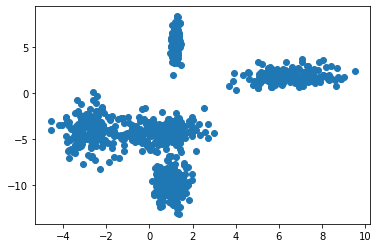

In [148]:
xscatter,yscatter = np.split(basedistrib.sample(1000).numpy(),2,axis=-1)
plt.scatter(xscatter,yscatter)

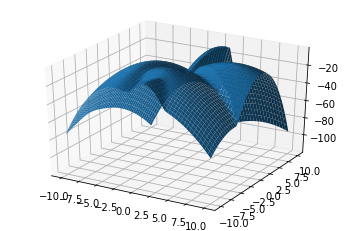

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lbplot = -10
ubplot = 10
X,Y = np.meshgrid(np.linspace(lbplot,ubplot),np.linspace(lbplot,ubplot))
XY_stack = np.stack([X,Y],axis=-1)
Z = basedistrib.logprob(XY_stack).numpy()
ax.plot_surface(X,Y,Z)

In [150]:
def base_positive_warps():
    warpf = utils.invsoftplus
    iwarpf = utils.softplus
    logdwarpf = lambda x : -torch.log(1.0-torch.exp(-x))
    return warpf,iwarpf,logdwarpf

def base_bounded_warps():
    #[0,1] -> R
    raise NotImplementedError
    return warpf,iwarpf,logdwarpf

In [151]:
def get_warps(lb,ub,scale=1.0):
    #warpf : bounds -> R
    #iwarpf : R -> bounds
    #logdwarpf = log|warpf'\ : bounds -> R^+
    if lb == None and ub == None:
        warpf = lambda x : x/scale
        iwarpf = lambda x : scale*x
        logdwarpf = lambda x : torch.zeros_like(x) - torch.log(scale)
    elif lb != None and ub == None:
        bwf,biwf,bdwf = base_positive_warps()
        warpf = lambda x : bwf((x-lb)/scale)
        iwarpf = lambda x :scale*biwf(x) + lb
        logdwarpf = lambda x : bdwf((x-lb)/scale) - torch.log(scale)
    elif lb == None and ub != None:
        raise NotImplementedError
    elif lb != None and ub != None:
        raise NotImplementedError
    return warpf,iwarpf,logdwarpf

In [152]:
class NamedDistribution(object):
    def __init__(self,params_name,params_dim,params_bound,basedistrib,params_scale=None):
        self.basedistrib = basedistrib
        assert self.basedistrib.ndim == sum(params_dim)
        self.set_param_distrib(params_name,params_dim,params_bound,params_scale)
        
    def logprob(self,params):
        #logdensity_{X}(x) = logdensity_{warp(X)}(warp(X)) + logdwarp(X) 
        #Ordering
        params_ = collections.OrderedDict([(key,params[key]) for key in self.names])
        joint_and_warped_x = self.join_and_warp_parameters(params)
        uncorrected_res = self.basedistrib.logprob(joint_and_warped_x)
        corrections = [self.logdwarpf(key)(value) for key,value in params_.items()]
        correction = torch.sum(torch.cat(corrections,dim=-1),dim=-1)
        print([self.logdwarpf(key)(value) for key,value in params_.items()])
        res = uncorrected_res + correction
        return res
    
    def sample(self,n):
        warped_samples = self.basedistrib.sample(n)
        samples = self.split_and_unwarp_parameters(warped_samples)
        return samples
    
    def set_param_distrib(self,params_name,params_dim,params_bound,params_scale):
        if params_scale is None:
            params_scale = dict()
        param_dict = collections.OrderedDict()
        for i,(name,dim,bounds) in enumerate(zip(params_name,params_dim,params_bound)):
            lb,ub = bounds
            scale = utils.tensor_convert(params_scale.get(name,1.0))
            warpf,iwarpf,logdwarpf = get_warps(lb,ub,scale)
            param_dict[name] = {'dim':dim,'bounds':bounds,
                                'warpf':warpf,'iwarpf':iwarpf,'logdwarpf':logdwarpf}
        self.param_dict = param_dict
    
    def join_parameters(self,params):
        return torch.cat([param[name] for name in self.names],dim=-1)
    
    def join_and_warp_parameters(self,params):
        tocat = [self.warpf(name)(params[name]) for name in self.names]
        res = torch.cat(tocat,dim=-1)
        return res
    
    def split_parameters(self,x):
        return torch.split(x,[self.dim(name) for name in self.names],dim=-1)

    def split_and_unwarp_parameters(self,x):
        splits = torch.split(x,[self.dim(name) for name in self.names],dim=-1)
        res = dict([(name,self.iwarpf(name)(splits[i])) for i,name in enumerate(self.names)])
        return res
    
    @property
    def names(self):
        return list(self.param_dict.keys())
    
    def dim(self,key):
        return self.param_dict[key]['dim']
    
    def bounds(self,key):
        return self.param_dict[key]['bounds']

    def warpf(self,key):
        return self.param_dict[key]['warpf']

    def iwarpf(self,key):
        return self.param_dict[key]['iwarpf']

    def logdwarpf(self,key):
        return self.param_dict[key]['logdwarpf']


In [153]:
params_name = ['mean','var']
params_dim = [1,1]
params_bound = [(None,None),(0.0,None)]
params_scale = {'mean':2.0}
distrib = NamedDistribution(params_name,params_dim,params_bound,basedistrib,params_scale)

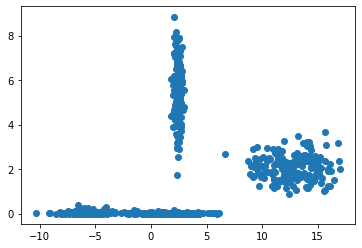

In [154]:
samples = distrib.sample(1000)
plt.scatter(samples['mean'].numpy(),samples['var'].numpy())

In [141]:
distrib.logprob(samples)

[tensor([[-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931],
        [-0.6931]]), tensor([[2.2731e-01],
        [2.8101e-03],
        [3.9229e-01],
        [6.5866e+00],
        [3.5519e-03],
        [3.2944e-01],
        [5.3944e-01],
        [2.8646e-03],
        [3.1784e-01],
        [4.6912e-03]])]


tensor([-3.1372, -5.3418, -3.8737,  2.2887, -2.5443, -3.4734, -3.6340, -4.3646,
        -4.9793, -7.8488])